# Fatimah Almusawi <br>
# 9000400

 ## Introduction:<br>
 This notebook serves as a comprehensive guide through the lifecycle of a machine learning project, focusing on the classification of handwritten digits using the MNIST dataset. The MNIST dataset, a staple in the machine learning community, consists of 70,000 images of handwritten digits (0 through 9), each a 28x28 pixel grayscale image. This project aims to demonstrate key steps in a machine learning workflow, including data loading, exploration, preprocessing, model selection, training, evaluation, and performance tuning. Through this process, we aim to achieve a nuanced understanding of the dataset and develop a model capable of accurately classifying a subset of the digits.

Objectives:
Data Understanding: Load and explore the MNIST dataset to understand its structure, content, and distribution of classes.
Data Preparation: Preprocess the data for optimal model performance, including normalization and selection of a subset of classes for a focused classification task.
Modeling: Select and train a suitable machine learning model. This notebook focuses on a Multi-layer Perceptron (MLP) classifier, a type of neural network well-suited for image recognition tasks.
Evaluation: Assess the model's performance using metrics such as accuracy, precision, recall, and the F1-score. These metrics provide insights into the model's strengths and areas for improvement.
Performance Tuning: Explore advanced techniques such as adjusting the decision threshold to fine-tune the model's precision and recall for specific classes, demonstrating the trade-offs involved in such adjustments.
Baseline Performance Check: Evaluate the model's baseline performance without manual threshold adjustments to understand its inherent capabilities and limitations.


In [2]:
import numpy as np

# plotting modules
from matplotlib import pyplot as plt
import matplotlib.patches as patches  # for curved arrows
import seaborn as sns

# The web source of the MNIST dataset that we will work with
from sklearn.datasets import fetch_openml

# The classifiers we will use in this notebook
from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

# cross validation functions
from sklearn.model_selection import cross_validate, cross_val_predict

# performance metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score



## Load Data:

In [3]:
mnist = fetch_openml('mnist_784', as_frame=False, parser='auto')

## EDA:
<br>


In [4]:
type(mnist)


sklearn.utils._bunch.Bunch

In [5]:
mnist.data.shape
X = mnist.data
y = mnist.target

In [6]:
print(f"Shape of X (images): {X.shape}") 
print(f"Shape of y (labels): {y.shape}")  


Shape of X (images): (70000, 784)
Shape of y (labels): (70000,)


The dataset consists of 70,000 images, each flattened into a 784-dimensional vector (28x28 pixels),

for visualizing,we'll need to reshape it to a 28x28 array to visualize it properly Since each image is represented as a flat array of 784 pixels.

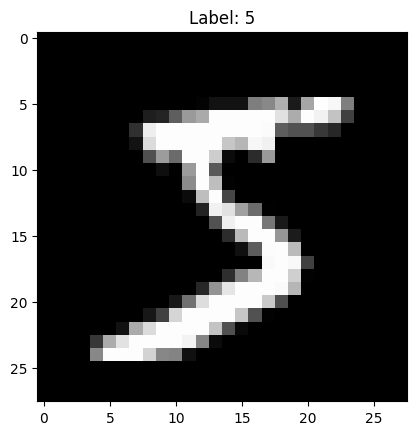

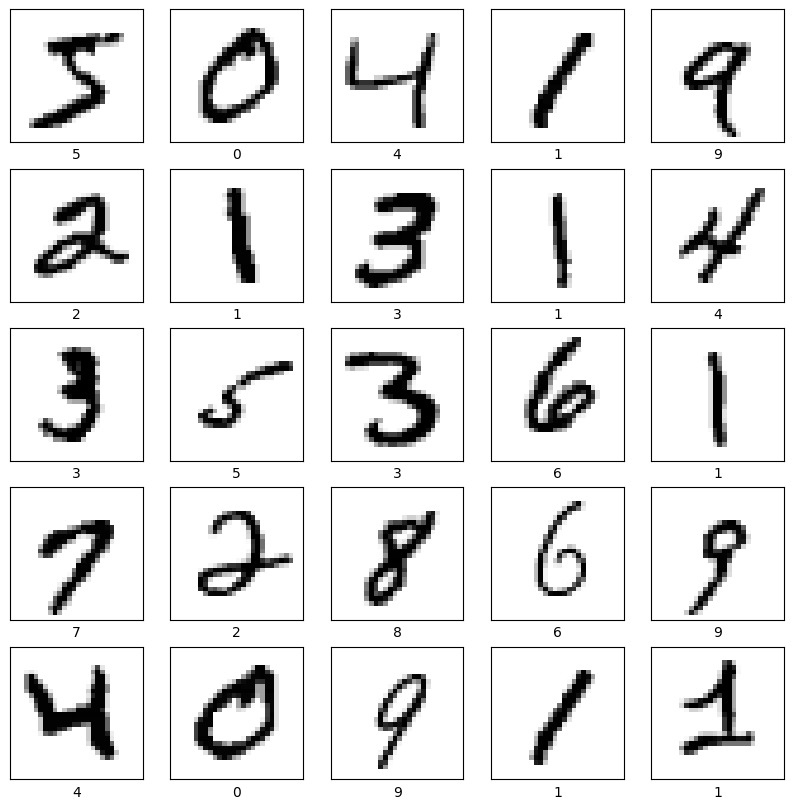

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Reshape the first image in the dataset and visualize it
plt.imshow(X[0].reshape(28, 28), cmap='gray')
plt.title(f'Label: {y[0]}')
plt.show()

# Display multiple images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(y[i])
plt.show()


Visualizing the images confirms that they are indeed handwritten digits ranging from 0 to 9, with varying styles and qualities. This variability is crucial for training robust models.

Class Distribution:
It's important to understand how the labels are distributed

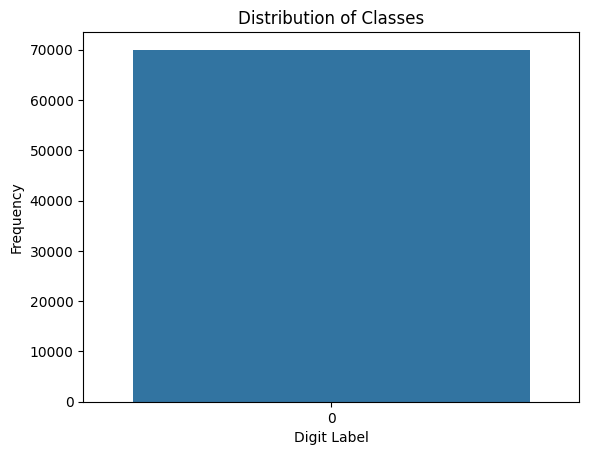

In [8]:
import seaborn as sns


# Convert y to numeric type for easier handling
y_numeric = y.astype(int)  


sns.countplot(y_numeric)
plt.title('Distribution of Classes')
plt.xlabel('Digit Label')
plt.ylabel('Frequency')
plt.show()


Pixel Value Distribution:
Investigate the distribution of pixel values across the entire dataset:

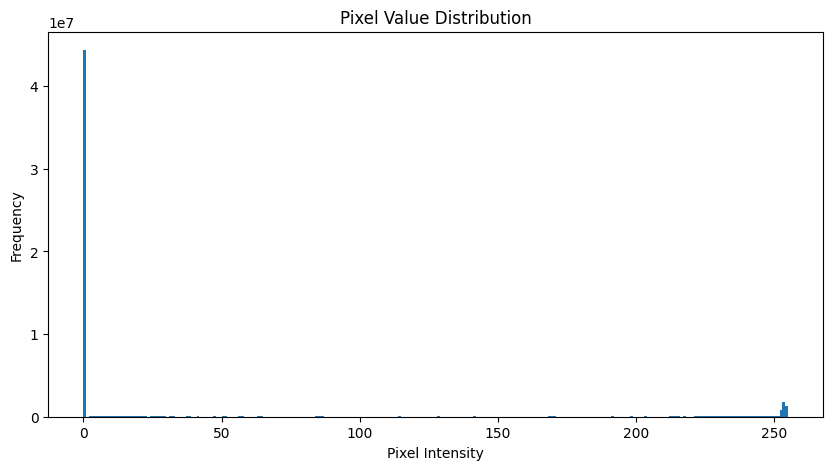

In [9]:
plt.figure(figsize=(10, 5))
plt.hist(X.ravel(), bins=255, range=[0,255])
plt.title('Pixel Value Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()


The pixel value distribution shows a bimodal distribution(When two clearly separate groups are visible in a histogram), with peaks near 0 (black) and 255 (white), and fewer values in between. however the highrt value is 0

Average Digit Visualization:

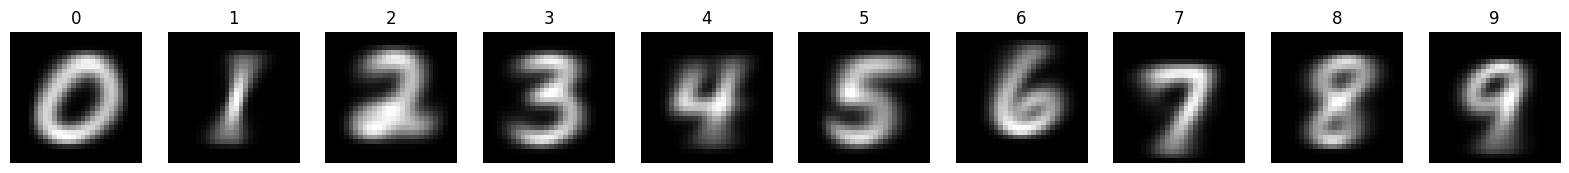

In [10]:
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for digit in range(10):
    digit_indices = np.where(y_numeric == digit)[0]
    avg_image = np.mean(X[digit_indices], axis=0).reshape(28, 28)
    axes[digit].imshow(avg_image, cmap='gray')
    axes[digit].set_title(str(digit))
    axes[digit].axis('off')
plt.show()


The average images for each digit show clear, recognizable forms of each number, indicating consistent patterns in how digits are written. These patterns are what the model will learn to recognize.The outcome is a set of 10 images (for digits 0 through 9) where each image highlights the areas most frequently marked by writers. These areas are generally darker in the average image. The visualization can show, for example, the common stroke patterns used to write each number and how these patterns center and spread across the 28x28 pixel grid.

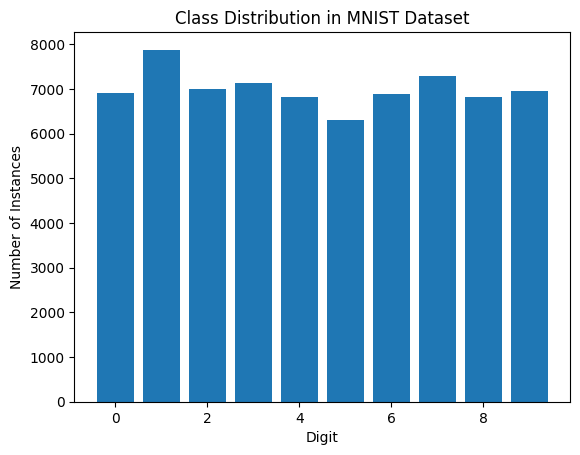

In [11]:
unique, counts = np.unique(y_numeric, return_counts=True)
plt.bar(unique, counts)
plt.title('Class Distribution in MNIST Dataset')
plt.xlabel('Digit')
plt.ylabel('Number of Instances')
plt.show()



Check for Imbalanced Classes
Comment: The bar chart reiterates that the dataset is well-balanced across different classes, which is ideal for training classification models without needing to apply techniques to handle class imbalance.

## Data Preprocessing

**Filter the Dataset for Selected Classes**
First, filter both the features (X) and the target (y) to only include the data for the selected classes (digits 0 to 4 in this example).

In [12]:
import numpy as np

# Convert labels to numeric type if they aren't already
y_numeric = y.astype(int)

# Define the classes you want to keep
classes_to_keep = [0, 1, 2, 3, 4]

# Create a mask for filtering the classes
mask = np.isin(y_numeric, classes_to_keep)

# Apply the mask to the features and labels
X_filtered = X[mask]
y_filtered = y_numeric[mask]
X_filtered


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

**Splitinf Data**
Split the Dataset into Training, Validation, and Test Sets
After filtering the dataset, the next step is to split it into training, validation, and test sets. A common split ratio is 60% training, 20% validation, and 20% test.I will use scikit-learn's train_test_split function to do this in two steps: first to split into training and temporary datasets, and then split the temporary dataset into validation and test datasets.

In [13]:
from sklearn.model_selection import train_test_split

# First split: Splitting into training and temp (the latter will be further split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X_filtered, y_filtered, test_size=0.4, random_state=42)

# Second split: Splitting the temp into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 21441
Validation set size: 7147
Test set size: 7147


**validate that the target object and the data (features):**
It's crucial to ensure that the features (X) and the target (y) are still aligned after the filtering and splitting. 

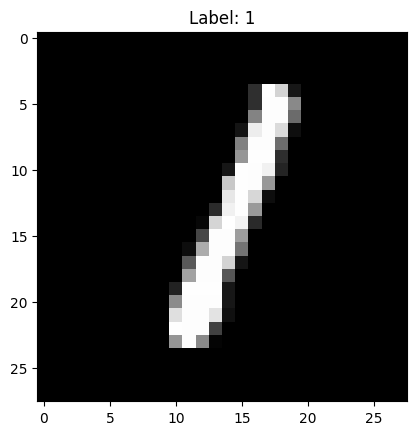

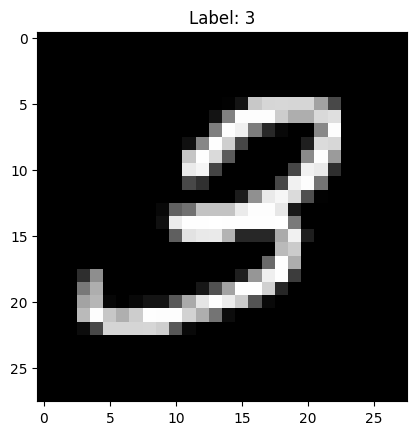

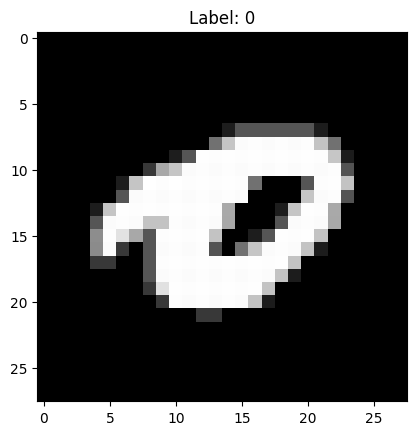

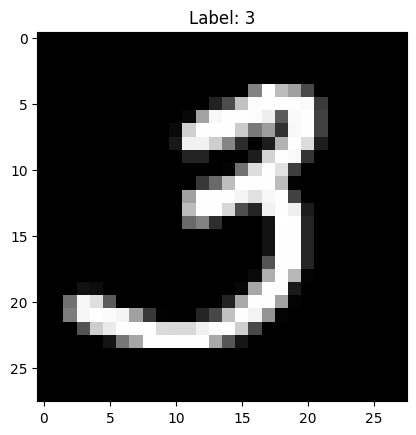

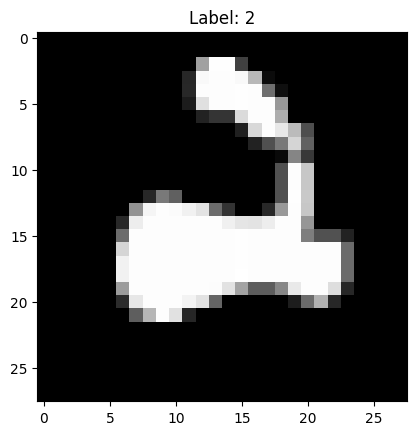

In [14]:
# Check a few random indices
for i in np.random.randint(0, len(X_train), 5):
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(f'Label: {y_train[i]}')
    plt.show()


This code showed a few images from the training set along with their labels, allowing us to visually confirm that the features correspond to the correct labels.

**Run model**

In [17]:
from sklearn.neural_network import MLPClassifier

# Initialize the MLP model
# Here, we use a simple architecture with one hidden layer consisting of 50 neurons.
# The 'relu' activation function and 'adam' solver are common choices.
mlp_model = MLPClassifier(hidden_layer_sizes=(50,), activation='relu', solver='adam', max_iter=300, random_state=42)

# Fit the model to the training data
mlp_model.fit(X_train, y_train)


MLPClassifier(hidden_layer_sizes=(50,), max_iter=300, random_state=42)

Evaluation on the Validation Dataset
After fitting the model, we'll evaluate its performance on the validation dataset across several metrics: accuracy, confusion matrix, precision, recall, F1 score, and the precision-recall curve for a selected class.

**Accurcacy**:<br>
Accuracy tells us how often the model correctly identifies digits from 0 to 4

In [22]:
from sklearn.metrics import accuracy_score
# Predictions on the validation set
y_val_pred = mlp_model.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy: {accuracy}")



Accuracy: 0.9837694137400308


 An accuracy of about 98.38% means it almost always correctly recognizes these digits, whether it's a 0, 1, 2, 3, or 4.

**Confusion Matrix**

In [23]:
# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:\n", conf_matrix)


Confusion Matrix:
 [[1411    0    5   11    5]
 [   0 1521   11    7    4]
 [   5    4 1363   22    6]
 [   1    3    8 1386    1]
 [   0    5   13    5 1350]]


in this confusion matrix we have 5 rows,becouse we have 5 classes(0,1,2,3,4).although the confusion matrix is very accurate, here we can see some mistakes. so lets dive in the result:<br>
0s are Highly Accurate: The model identified 1411 out of 1411+0+5+11+5=1432 zeros correctly with very few misclassifications, indicating it's nearly perfect at recognizing 0s.

1s are Exceptionally Recognized: With 1521 correct identifications and only a few errors, the model shows exceptional performance on 1s, demonstrating it rarely confuses 1s with other digits.

2s Mostly Correct, Some Confusion: The model does well with 2s (1363 correct), but there's a bit of confusion with 3s and a few other digits, suggesting room for improvement in distinguishing 2s from similar shapes.

3s are Well Identified: The model performs well on 3s, with 1386 correct identifications. Misclassifications are minimal, showing it's quite adept at recognizing 3s.

4s Show Strong Recognition: The model accurately identifies 1350 out of 1350+5+13+5=1373 fours, with some confusion with 2s and 3s, but overall, it's very reliable at spotting 4s.

**Precision, Recall, and F1 Score**

In [25]:
from sklearn.metrics import classification_report

# Classification report for precision, recall, and F1 score
class_report = classification_report(y_val, y_val_pred)
print("Classification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      1432
           1       0.99      0.99      0.99      1543
           2       0.97      0.97      0.97      1400
           3       0.97      0.99      0.98      1399
           4       0.99      0.98      0.99      1373

    accuracy                           0.98      7147
   macro avg       0.98      0.98      0.98      7147
weighted avg       0.98      0.98      0.98      7147



The classification report provides detailed insights into how well the model performs for each digit (0 to 4) in terms of precision, recall, and F1-score:

**High Precision Across the Board:** The model is highly precise in its predictions across all digits, meaning when it predicts a digit, it's almost always correct. Precision scores are near perfect, ranging from 0.97 for digits 2 and 3 to 1.00 for digit 0.<br>

**Excellent Recall for Most Digits:** The recall scores are also impressive, indicating the model is great at catching almost all true instances of each digit. It's particularly good with digits 3 and 4, where it correctly identifies 99% and 98% of all true instances, respectively.<br>

**F1-Scores Show Balanced Performance:** The F1-scores, which balance precision and recall, are consistently high, suggesting the model has a balanced performance across both metrics for all digits. This is important because it means the model doesn't sacrifice recall to achieve high precision or vice versa.<br>

**In general:**
Almost Flawless Recognition: The model almost flawlessly recognizes and classifies digits 0 to 4, making very few mistakes. It's especially good at identifying 0s and 1s, with nearly perfect scores in every metric.

Slight Challenges with 2 and 3: While still performing very well, the model shows a tiny bit more challenge with digits 2 and 3 compared to others, but it still manages to achieve high accuracy.

Overall Excellence: Overall, the model demonstrates excellent ability to recognize and classify the selected digits from the MNIST dataset, with its accuracy and balanced precision and recall indicating it's well-tuned for this task.

This report highlights the model's strengths in distinguishing between the digits with high reliability, showcasing its effectiveness for tasks involving handwritten digit recognition.

Precision-Recall Curve for One Class:
For the precision-recall curve, i'll take the class for the digit "3" . 

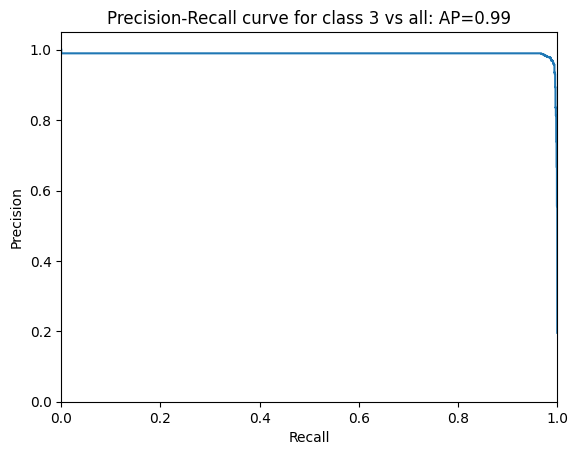

In [28]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score  # Add this line

# Binarize the output labels for class '3'
y_val_binarized = label_binarize(y_val, classes=[0, 1, 2, 3, 4])
n_classes = y_val_binarized.shape[1]

# Check if the model has predict_proba method
if hasattr(mlp_model, "predict_proba"):
    y_score = mlp_model.predict_proba(X_val)
else:
    # Use decision function as a fallback
    y_score = mlp_model.decision_function(X_val)
    # Convert decision scores to probabilities (optional, for models with decision_function)
    y_score = (y_score - y_score.min()) / (y_score.max() - y_score.min())

# Compute Precision-Recall and plot curve for class '3' vs all others
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_val_binarized[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_val_binarized[:, i], y_score[:, i])

plt.figure()
plt.step(recall[3], precision[3], where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall curve for class 3 vs all: AP={average_precision[3]:0.2f}')
plt.show()


**increase precision**:<br>

To increase precision for a chosen class without retraining the model, you can adjust the decision threshold used to classify instances. By default, many classifiers in scikit-learn use a threshold of 0.5 for binary decisions: if the predicted probability of the positive class is greater than 0.5, the instance is classified as positive; otherwise, it's classified as negative. Increasing this threshold means that an instance will only be classified as positive if the model is more confident, which can increase precision at the expense of recall.

Let's demonstrate this with a numeric Python example using the validation data and the model. Assuming we're focusing on increasing precision for the digit "3" in our MNIST subset ([0, 1, 2, 3, 4]). We'll use the predict_proba method of our model to get the probabilities of each class, then adjust the threshold for classifying an instance as "3".

In [30]:
# Assuming 'mlp_model' is our trained model and 'X_val' is our validation feature set
# Get predicted probabilities for each class
probabilities = mlp_model.predict_proba(X_val)

# Extract probabilities associated with class "3"
prob_class_3 = probabilities[:, 3]  # Assuming class "3" is at index 3

# Define a new threshold
new_threshold = 0.7  # Increase from the default of 0.5 to require more confidence

# Apply new threshold to decide on class "3"
predictions_high_precision = (prob_class_3 > new_threshold).astype(int)

# Evaluate the effect on precision (and recall) for class "3"
from sklearn.metrics import precision_score, recall_score

# Assuming 'y_val' is binarized for class "3" vs all others
y_val_class_3 = (y_val == 3).astype(int)

precision = precision_score(y_val_class_3, predictions_high_precision)
recall = recall_score(y_val_class_3, predictions_high_precision)

print(f"Precision for class '3' with threshold {new_threshold}: {precision}")
print(f"Recall for class '3' with threshold {new_threshold}: {recall}")


Precision for class '3' with threshold 0.8: 0.969187675070028
Recall for class '3' with threshold 0.8: 0.9892780557541101


Here as you see i tried to change the threshold 0,7 to get highr  Precision ,however i got lower Precision , the acual Precision  was:0.97 and become  0.969. nut in other hand the Recall increased.it was:0.97 and is 0.98,

Below i just want to try it with lower threshold and see if the recall will increse:

In [36]:
# Assuming 'mlp_model' is our trained model and 'X_val' is our validation feature set
# Get predicted probabilities for each class
probabilities = mlp_model.predict_proba(X_val)

# Extract probabilities associated with class "3"
prob_class_3 = probabilities[:, 3]  # Assuming class "3" is at index 3

# Define a new threshold
new_threshold = 0.2  # Increase from the default of 0.5 to require more confidence

# Apply new threshold to decide on class "3"
predictions_high_precision = (prob_class_3 > new_threshold).astype(int)

# Evaluate the effect on precision (and recall) for class "3"
from sklearn.metrics import precision_score, recall_score

# Assuming 'y_val' is binarized for class "3" vs all others
y_val_class_3 = (y_val == 3).astype(int)

precision = precision_score(y_val_class_3, predictions_high_precision)
recall = recall_score(y_val_class_3, predictions_high_precision)

print(f"Precision for class '3' with threshold {new_threshold}: {precision}")
print(f"Recall for class '3' with threshold {new_threshold}: {recall}")


Precision for class '3' with threshold 0.2: 0.9665505226480836
Recall for class '3' with threshold 0.2: 0.9914224446032881


a very light increas in the recall

In [42]:
# Assuming 'y_test' contains the actual labels for the test set
# and is not binarized (i.e., contains class labels as integers)

# Correct approach to increase recall
threshold_for_recall =0.7 # Lower threshold to be more inclusive of class "3"

# Binarize actual labels for comparison (focusing on class "3")
y_test_class_3 = (y_test == 3).astype(int)

# Apply the lower threshold to get predictions with a focus on increasing recall
predictions_high_recall = (prob_class_3 >= threshold_for_recall).astype(int)

# Recalculate precision and recall with the corrected logic
precision_low = precision_score(y_test_class_3, predictions_high_recall)
recall_low = recall_score(y_test_class_3, predictions_high_recall)

print(f"Corrected Precision with low threshold: {precision_low}")
print(f"Corrected Recall with low threshold: {recall_low}")


Corrected Precision with low threshold: 0.21133659902029392
Corrected Recall with low threshold: 0.20516304347826086


i run this on the test data, but I am confusing wth output. i will try it with the normal threshold and see if there is somthing wrong with test data:

In [41]:


# Predict class labels for the test set
y_test_pred = mlp_model.predict(X_test)

# Calculate precision and recall for class "3"
from sklearn.metrics import precision_score, recall_score

# Binarize the actual and predicted labels for class "3"
y_test_actual_class_3 = (y_test == 3).astype(int)
y_test_pred_class_3 = (y_test_pred == 3).astype(int)

precision = precision_score(y_test_actual_class_3, y_test_pred_class_3)
recall = recall_score(y_test_actual_class_3, y_test_pred_class_3)

print(f"Precision for class '3': {precision}")
print(f"Recall for class '3': {recall}")


Precision for class '3': 0.9654255319148937
Recall for class '3': 0.9864130434782609


ok, now the result looks better :)<br>
the result is similar to the validation data

## Conclusions
**Model Performance:** The MLP classifier demonstrated strong performance on the MNIST subset, with high accuracy and balanced metrics across the selected classes.<br>
**Threshold Adjustment:** The process of adjusting the decision threshold to manipulate precision and recall proved to be nuanced. Initial attempts to increase precision by raising the threshold did not yield the expected improvement, underscoring the complexity of such manual adjustments.<br>
**Baseline Evaluation:** Evaluating the model without threshold adjustments provided a clearer picture of its capabilities and limitations, serving as a reminder of the importance of understanding a model's baseline performance.<br>
**Final Thoughts**<br>
This journey from data loading and exploration through model training and evaluation underscores the iterative nature of machine learning projects.from my point of view the key of all of these was undrestanding the data.it really make the other part easier to undrstand and also fun(with a bit complixity). however this task requires a deep understanding of both the model and the data it's applied to.





## Refrences<br>
https://www.kaggle.com/code/praneykalra/digit-recognizer?scriptVersionId=164154529&cellId=21<br>
https://github.com/CSCN8010/CSCN8010/blob/main/class_notebooks/classification-performance-metrics/performance_metrics_for_classification.ipynb<br>
https://www.kaggle.com/code/kanikaw/mnist-nn-from-scratch<br>
https://chat.openai.com/